## **Mounting Drive**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# **Installing & Importing Libraries**

In [ ]:
!pip install pandas
!pip install torch
# load tqdm
!pip install --force https://github.com/chengs/tqdm/archive/colab.zip
!pip install nltk
!pip install textblob wordcloud matplotlib
!pip install transformers

     - 91.8 kB 1.2 MB/s 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for tqdm: filename=tqdm-4.28.1-py2.py3-none-any.whl size=47876 sha256=b0e3a28d7ea40ceafccb18755d83ff12e88f3340a9c1c4f0373ae6c49b2f8d40
  Stored in directory: /tmp/pip-ephem-wheel-cache-d2dgjj4q/wheels/65/77/d5/d5ddeac9924f01d101ed3d2bf420c627eba535f8b8d93f27ee
Successfully built tqdm
  Attempting uninstall: tqdm
    Found existing installation: tqdm 4.66.1
    Uninstalling tqdm-4.66.1:
      Successfully uninstalled tqdm-4.66.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
huggingface-hub 0.19.4 requires tqdm>=4.42.1, but you have tqdm 4.28.1 which is incompatible.
panel 1.3.1 requires tqdm>=4.48.0, but you have tqdm 4.28.1 which is incompatible.
prophet 1.1.5 requires tqdm>=4.36.1, but you have tqdm 4.28.1 which is incompatible.
spacy 3.6.1 requires tqdm<5.0.0,>=4.38.0, 

## **Imports**

In [ ]:
from argparse import Namespace
from collections import Counter
import json
import os
import re
import string

import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchtext.data.utils import get_tokenizer
from torchtext.vocab import Vocab
from tqdm import tqdm_notebook
import nltk
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer

nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('omw-1.4')
from nltk.corpus import stopwords
from textblob import TextBlob
from wordcloud import WordCloud
import matplotlib.pyplot as plt

from transformers import AutoTokenizer, AutoModelForSequenceClassification
from torch.utils.data import DataLoader

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...


### **Checking the StopWords list.**

In [ ]:
print(stopwords.words('english'))

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so', 'than', '

## **Class Definitions:**
1. class ReviewDataset : Which loads the Dataset, Cleans and instantiates and object to call the tokenize and lemmatize methods.
2. class Tokenizer : Contains the tokenize and lemmatize methods.

In [ ]:
class ReviewDataset(Dataset):

  def __init__(self,review_df,tokenizer):
    self.review_df = review_df
    self.tokenizer = tokenizer

  @staticmethod
  def dataset_cleaning(review_df):
    # Data Cleaning and lowering of all comments.

    review_df['comment'] = review_df['comment'].str.strip()
    review_df['comment'] = review_df['comment'].str.lstrip('✅ Trip Verified | ')
    review_df['comment'] = review_df['comment'].str.lstrip('Not Verified | ')
    review_df['comment'] = review_df['comment'].str.lower()
    return review_df['comment']

  @classmethod
  def load_dataset_and_tokenizer(cls, review_csv, stop_words):
    review_df = pd.read_csv(review_csv)
    clean_review_df = cls.dataset_cleaning(review_df)
    print(clean_review_df.head())
    print('Data Cleaned')

    # Tokenize the comments
    tokenizer = Tokenizer(stop_words=stop_words)
    token_review_df = clean_review_df.apply(tokenizer.tokenize)
    print(token_review_df.head())
    print('Tokenized')

    # Lemmatize the comments
    lemma_review_df = token_review_df.apply(tokenizer.lemmatize)
    print(lemma_review_df.head())
    print('Lemmatized')

    return review_df, cls(lemma_review_df, tokenizer)
  @classmethod
  def stop_words(cls):
    # store the set of english stopwords from nltk as a variable to be used later
    stop_words = set(stopwords.words('english'))
    # Add some additional words to the stop words list
    stop_words.update(['ba','verified','trip', 'british', 'airway', 'airways', 'airline', 'airlines' ,'review','airport','aircraft','flight','plane'])
    return(stop_words)

class Tokenizer(object):

    def __init__(self, stop_words):
      self.stop_words = stop_words

    # To remove the stop_words and Tokenizing
    def tokenize(self, comment):
      # Tokenize the comment
      tokens = word_tokenize(comment)
      # Remove stop words
      tokens = [token for token in tokens if token not in self.stop_words and len(token) > 3]
      return tokens

    # To lemmatize the tokens
    def lemmatize(self,tokens):
      lemmatizer = WordNetLemmatizer()
      lemmatized_tokens = [lemmatizer.lemmatize(token) for token in tokens]
      return lemmatized_tokens


args = Namespace(
    # Data and Path information,
    df ='/content/drive/MyDrive/British_Airways.csv',
)

stop_words = ReviewDataset.stop_words()  # Calling the @staticmethod of ReviewDataset class
review_df, dataset = ReviewDataset.load_dataset_and_tokenizer(args.df, stop_words) # Calling the class method of ReviewDataset class


0    y competent check in staff, saw had a problem ...
1    check in was so slow, no self check in and bag...
2    my review relates to the appalling experiences...
3    his was my first time flying with ba & i was p...
4    lots of cancellations and delays and no one ap...
Name: comment, dtype: object
Data Cleaned
0    [competent, check, staff, problem, left, insis...
1    [check, slow, self, check, drop, boarding, tot...
2    [relates, appalling, experiences, 14th, februa...
3    [first, time, flying, pleasantly, surprised, i...
4    [lots, cancellations, delays, apologized, edin...
Name: comment, dtype: object
Tokenized
0    [competent, check, staff, problem, left, insis...
1    [check, slow, self, check, drop, boarding, tot...
2    [relates, appalling, experience, 14th, februar...
3    [first, time, flying, pleasantly, surprised, i...
4    [lot, cancellation, delay, apologized, edinbur...
Name: comment, dtype: object
Lemmatized


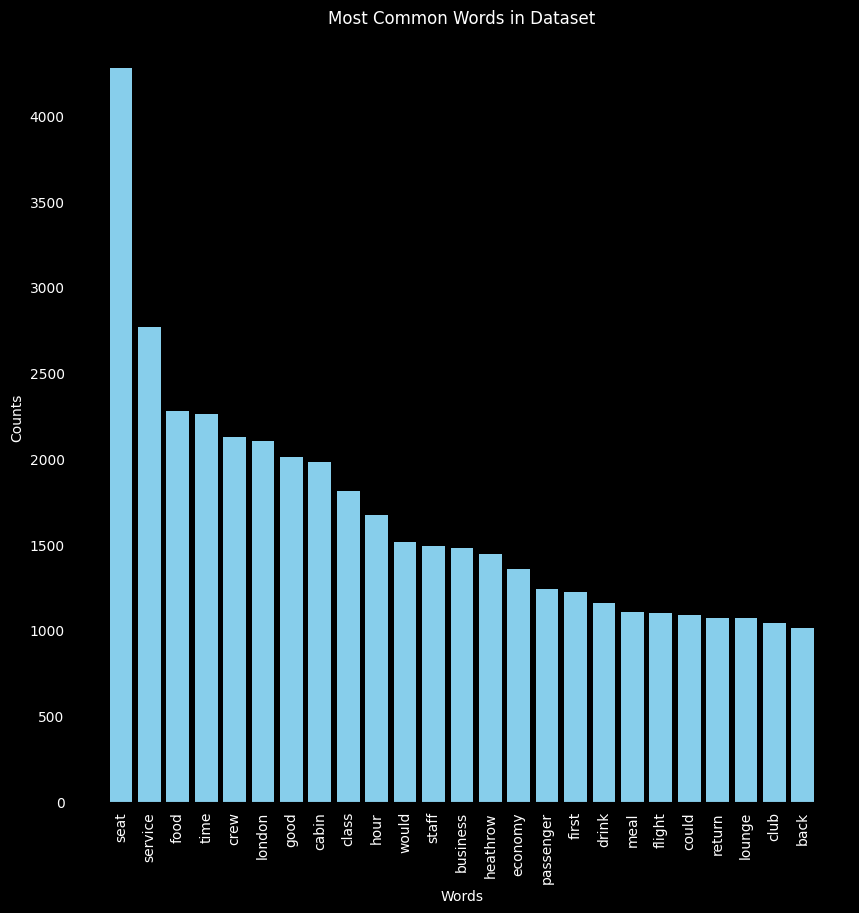

In [ ]:
# create a Counter object from the list of tokenized sentences
word_counts = Counter([word for sentence in dataset.review_df for word in sentence])

# get the most common words and their counts
most_common = word_counts.most_common(25)

# extract the words and their counts into separate lists
words = [word[0] for word in most_common]
counts = [word[1] for word in most_common]

# create a bar plot of the word counts
plt.figure(figsize=(10,10))
# Set the figure background color
plt.gcf().set_facecolor('black')
plt.gca().set_facecolor('black')
plt.bar(words, counts, color='skyblue')

# Set the color of the axis labels to white
plt.xlabel('Words', color='white')
plt.ylabel('Counts', color='white')

plt.xticks(rotation=90, color='white')
plt.yticks(color='white')
# Set the title of the plot with light text
plt.title('Most Common Words in Dataset', color='white')

plt.show()

As we can see a lot of people have a lot to say about seat , service, food etc. We are going to soon find out how good or bad that is.

In [ ]:
lemma_review_str = " ".join([" ".join(review) for review in dataset.review_df])

# Create a TextBlob object
polarity_scores = []
for review in dataset.review_df:
    review_str = ' '.join(review)
    blob = TextBlob(review_str)
    polarity_scores.append(blob.sentiment.polarity)

avg_polarity = sum(polarity_scores) / len(polarity_scores)
print(f"Average Polarity: {avg_polarity:.2f}")

Average Polarity: 0.10


Average Polarity from the textblob gives quite a neutral result of 0.10 as Avg Polarity Scores vary from [-1,+1] with -1 being the most negative and +1 being the most positive.

## **Word Cloud of Sentiment of Customer Reviews**

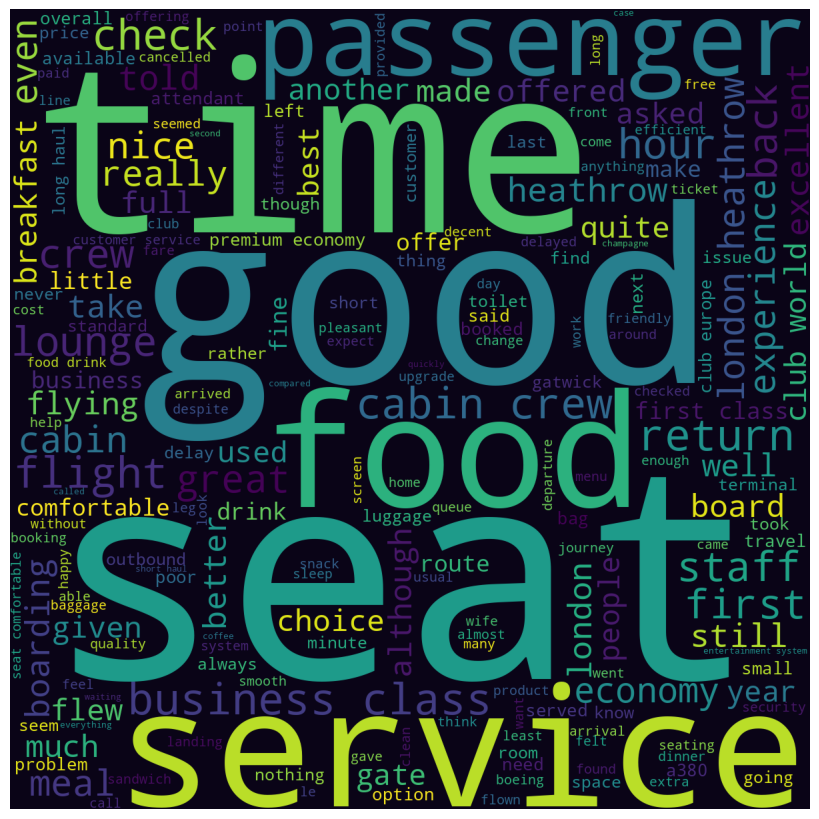

In [ ]:
# Define the sentiment categories
positive = 0
negative = 0
neutral = 0

# Calculate the percentage of positive, negative, and neutral sentiments
for score in polarity_scores:
    if score > 0:
        positive += 1
    elif score < 0:
        negative += 1
    else:
        neutral += 1

total = positive + negative + neutral


positive_percent = positive / total * 100
negative_percent = negative / total * 100
neutral_percent = neutral / total * 100

# Generate a WordCloud object for positive sentiment
positive_reviews = [review for i, review in enumerate(dataset.review_df) if polarity_scores[i] > 0]
positive_review_str = " ".join([" ".join(review) for review in positive_reviews])
positive_wordcloud = WordCloud(width=1200, height=1200,
                               background_color='#0a0417',
                               min_font_size=10).generate_from_text(positive_review_str)

# Plot the WordCloud for positive sentiment
plt.figure(figsize=(8, 8), facecolor=None)
plt.imshow(positive_wordcloud)
plt.axis("off")
plt.tight_layout(pad=0)
plt.show()

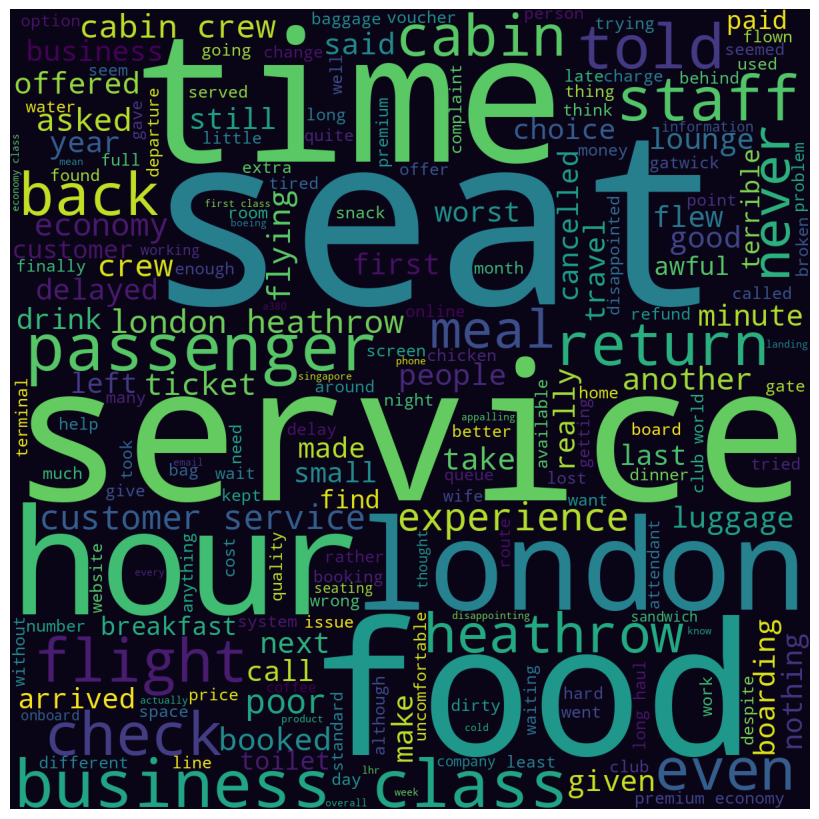

In [ ]:
# Generate a WordCloud object for negative sentiment
negative_reviews = [review for i, review in enumerate(dataset.review_df) if polarity_scores[i] < 0]
negative_review_str = " ".join([" ".join(review) for review in negative_reviews])
negative_wordcloud = WordCloud(width=1200, height=1200,
                               background_color='#0a0417',
                               min_font_size=10).generate_from_text(negative_review_str)

# Plot the WordCloud for negative sentiment
plt.figure(figsize=(8, 8), facecolor=None)
plt.imshow(negative_wordcloud)
plt.axis("off")
plt.tight_layout(pad=0)
plt.show()

As we can see most of our words have been used in both negative and positive sentiment of reviews. But there are few exceptions as well like cabin, crew are pretty big positive points as seen from the text blob analysis.

## **Percentage Distribution of Customer Reviews**
Let's calculate the percentage distribution of positive,neutral and negative sentiment of reviews and plot it in a pie chart.

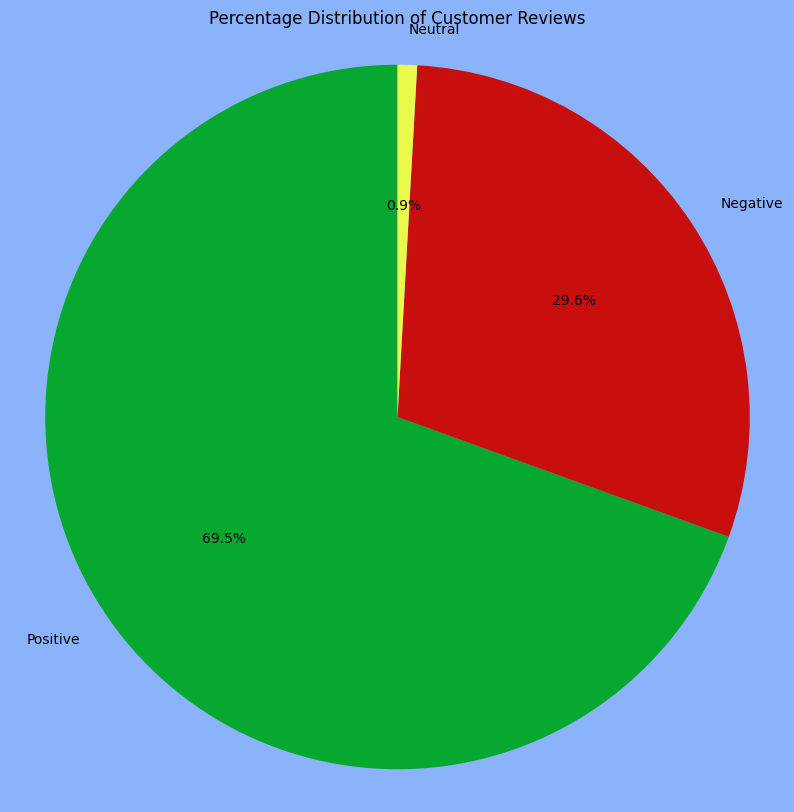

In [ ]:
# Create the pie chart
labels = ['Positive', 'Negative', 'Neutral']
sizes = [positive_percent, negative_percent, neutral_percent]
colors = ['#07a82f', '#c90e0e', '#e9fa4d']

fig1, ax1 = plt.subplots()
plt.title("Percentage Distribution of Customer Reviews")
# change the width and length of plot
fig1.set_figwidth(10)
fig1.set_figheight(10)
ax1.pie(sizes, colors=colors, labels=labels, autopct='%1.1f%%', startangle=90)
ax1.axis('equal')
fig1.set_facecolor('#8bb3fc')

plt.show()

We have more positive reviews(69.5%) than a negative reviews(29.6%) which is a good overall user expercience. Only 0.9% is for netural reviews.

## **Sentiment Count of Customer Reviews**
Count of Positive, Negative or Neutral reviews and plotting it in a bar graph.

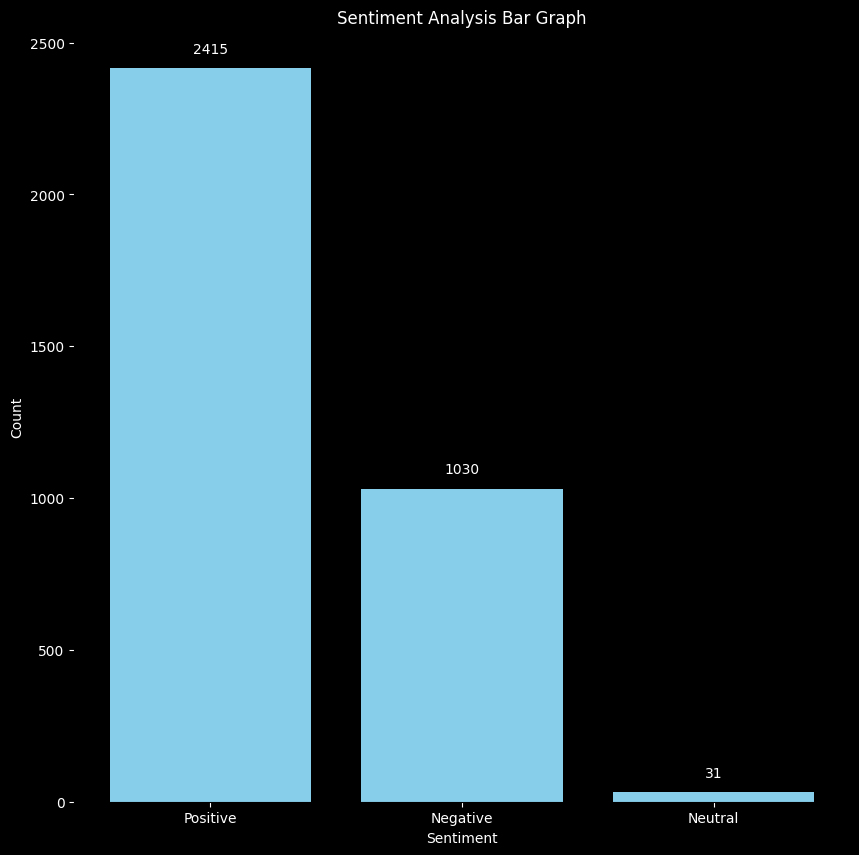

In [ ]:
# Create a bar graph of the sentiment counts
plt.figure(figsize=(10, 10))

# Define the categories and their values
x = ['Positive', 'Negative', 'Neutral']
y = [positive, negative, neutral]

# Create the bars and set a dark background
plt.bar(x, y, color='skyblue')

# Add labels to the bars with light text
for i, v in enumerate(y):
    plt.text(i, v + 50, str(v), ha='center', color='white')

# Set plot title and axis labels with light text
plt.title('Sentiment Analysis Bar Graph', color='white')
plt.xlabel('Sentiment', color='white')
plt.ylabel('Count', color='white')

# Set the background color
plt.gca().set_facecolor('black')  # Set the axes background color
plt.gcf().set_facecolor('black')  # Set the figure background color

# Set the color of the axis ticks to light color
plt.tick_params(axis='x', colors='white')
plt.tick_params(axis='y', colors='white')

# Show the plot
plt.show()


We have double the number of positive reviews than negative reviews. Which means customer are more happy with their experience of travelling with British Airways in general.

In [ ]:
review_df

,Unnamed: 0,date,rating,rev_id,Aircraft,Type Of Traveller,Seat Type,Route,Date Flown,Seat Comfort,Cabin Staff Service,Food & Beverages,Ground Service,Value For Money,Recommended,comment,Inflight Entertainment,Wifi & Connectivity
0,0,2023-02-23,4,835501,A320,Couple Leisure,Economy Class,Faro to Gatwick,February 2023,2.0,2.0,1.0,5.0,2.0,no,"y competent check in staff, saw had a problem ...",NaN,NaN
1,1,2023-02-18,5,834045,A320,Family Leisure,Economy Class,Oslo to London,February 2023,3.0,3.0,1.0,2.0,3.0,no,"check in was so slow, no self check in and bag...",NaN,NaN
2,2,2023-02-18,1,833914,A320,Solo Leisure,Economy Class,London to Madrid,February 2023,2.0,1.0,1.0,1.0,2.0,no,my review relates to the appalling experiences...,NaN,NaN
3,3,2023-02-16,8,833402,NaN,Couple Leisure,Economy Class,Islamabad to London,February 2023,4.0,5.0,2.0,4.0,5.0,yes,his was my first time flying with ba & i was p...,3.0,NaN
4,4,2023-02-15,1,833131,NaN,Couple Leisure,Economy Class,Edinburgh to London,February 2023,3.0,2.0,NaN,1.0,1.0,no,lots of cancellations and delays and no one ap...,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3471,3471,2012-08-29,4,244109,NaN,NaN,Economy Class,NaN,NaN,2.0,3.0,1.0,NaN,3.0,no,lhr-jfk-lax-lhr. check in was ok apart from be...,4.0,NaN
3472,3472,2012-08-28,9,243823,NaN,NaN,Business Class,NaN,NaN,4.0,5.0,4.0,NaN,3.0,yes,lhr to ham. purser addresses all club passenge...,NaN,NaN
3473,3473,2011-10-12,5,243776,NaN,NaN,Economy Class,NaN,NaN,NaN,NaN,NaN,NaN,4.0,yes,my son who had worked for british airways urge...,NaN,NaN
3474,3474,2011-10-11,4,243824,NaN,NaN,Premium Economy,NaN,NaN,1.0,3.0,5.0,NaN,1.0,no,london city-new york jfk via shannon on a318 b...,NaN,NaN


In [ ]:
review_df.isnull().sum()

Unnamed: 0                   0
date                         0
rating                       0
rev_id                       0
Aircraft                  1657
Type Of Traveller          770
Seat Type                    2
Route                      774
Date Flown                 778
Seat Comfort               100
Cabin Staff Service        108
Food & Beverages           339
Ground Service             838
Value For Money              1
Recommended                  0
comment                      0
Inflight Entertainment    1045
Wifi & Connectivity       2957
dtype: int64

In [ ]:
review_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3476 entries, 0 to 3475
Data columns (total 18 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Unnamed: 0              3476 non-null   int64  
 1   date                    3476 non-null   object 
 2   rating                  3476 non-null   object 
 3   rev_id                  3476 non-null   int64  
 4   Aircraft                1819 non-null   object 
 5   Type Of Traveller       2706 non-null   object 
 6   Seat Type               3474 non-null   object 
 7   Route                   2702 non-null   object 
 8   Date Flown              2698 non-null   object 
 9   Seat Comfort            3376 non-null   float64
 10  Cabin Staff Service     3368 non-null   float64
 11  Food & Beverages        3137 non-null   float64
 12  Ground Service          2638 non-null   float64
 13  Value For Money         3475 non-null   float64
 14  Recommended             3476 non-null   

We can do some basic Data Analysis from the given Data.
Like : Dates, Rating, Reccommended have no Null object along with Seat type and Value for money also has very less Null Values which we can remove and still do some Analysis.
1. We can compare the Dateflown with Rating Categories to find a trend. To look if seasonal holidays etc has any effect on the Rating.
2.  To compare seat type with Rating and Recommended.
3. Seat type , Cabin Staff service vs Rating and Recommneded. After removing the respective missing values. Which is feasible as we won't lose too much of Data.

But first we need to do some cleaning and Type casting our Data types properly.
1. Convert Date & Dateflown which is in object to Datetime of pandas.
2. Rating which is in object to Numeric float64.



In [ ]:
# convert rating column to float64
review_df['rating'] = review_df['rating'].astype(float)

# print the updated dataframe data types
print(review_df.dtypes)

ValueError: ignored

In [ ]:
# filter dataframe to rows with non-numeric rating values
invalid_rows = review_df.loc[~review_df['rating'].str.isnumeric()]

# display the invalid rows
print(invalid_rows)

      Unnamed: 0        date rating  rev_id Aircraft Type Of Traveller  \
2903        2903  2015-02-18     na  243944      NaN               NaN   
3026        3026  2014-12-10     na  244636      NaN               NaN   
3046        3046  2014-11-25     na  244658      NaN               NaN   
3283        3283  2014-07-31     na  244460      NaN               NaN   
3317        3317  2014-07-15     na  244495      NaN               NaN   

           Seat Type Route Date Flown  Seat Comfort  Cabin Staff Service  \
2903   Economy Class   NaN        NaN           3.0                  5.0   
3026     First Class   NaN        NaN           1.0                  5.0   
3046   Economy Class   NaN        NaN           3.0                  3.0   
3283  Business Class   NaN        NaN           1.0                  1.0   
3317   Economy Class   NaN        NaN           1.0                  3.0   

      Food & Beverages  Ground Service  Value For Money Recommended  \
2903               1.0     

In [ ]:
invalid_rows

,Unnamed: 0,date,rating,rev_id,Aircraft,Type Of Traveller,Seat Type,Route,Date Flown,Seat Comfort,Cabin Staff Service,Food & Beverages,Ground Service,Value For Money,Recommended,comment,Inflight Entertainment,Wifi & Connectivity
2903,2903,2015-02-18,na,243944,NaN,NaN,Economy Class,NaN,NaN,3.0,5.0,1.0,NaN,2.0,no,cabin crew polite unfortunately ba ran out of ...,1.0,NaN
3026,3026,2014-12-10,na,244636,NaN,NaN,First Class,NaN,NaN,1.0,5.0,4.0,NaN,2.0,no,phoenix to london - outbound a wonderful and e...,2.0,NaN
3046,3046,2014-11-25,na,244658,NaN,NaN,Economy Class,NaN,NaN,3.0,3.0,2.0,NaN,3.0,no,on past experience i chose ba for our long hau...,1.0,NaN
3283,3283,2014-07-31,na,244460,NaN,NaN,Business Class,NaN,NaN,1.0,1.0,1.0,NaN,1.0,no,lhr-cph-lhr business class. this is a joke. sc...,1.0,NaN
3317,3317,2014-07-15,na,244495,NaN,NaN,Economy Class,NaN,NaN,1.0,3.0,1.0,NaN,1.0,no,i flew with british airways with my mother fro...,1.0,NaN


Okay after reading the 5 reviews which had 'na' instead of any numeric values. It's pretty clear they had such a terrible experience that they refused to even rate as probably giving 0 as a rating is not possible. It's on a scale of 1-10.
What we can do is convert those values of 'na' to 0. So, that we can use them for further analysis.

In [ ]:
# Replace 'na' values in the rating column with 0
review_df['rating'] = review_df['rating'].replace('na', 0)

# Convert the rating column to numeric type
review_df['rating'] = pd.to_numeric(review_df['rating'])

In [ ]:
review_df.dtypes

Unnamed: 0                  int64
date                       object
rating                      int64
rev_id                      int64
Aircraft                   object
Type Of Traveller          object
Seat Type                  object
Route                      object
Date Flown                 object
Seat Comfort              float64
Cabin Staff Service       float64
Food & Beverages          float64
Ground Service            float64
Value For Money           float64
Recommended                object
comment                    object
Inflight Entertainment    float64
Wifi & Connectivity       float64
dtype: object

In [ ]:
# Dropping the redundant column

review_df.drop(columns=['Unnamed: 0'], inplace=True)

# Converting 'date' and 'Date Flown' columns to datetime format

review_df['date'] = pd.to_datetime(review_df['date'], errors='coerce')

review_df['Date Flown'] = pd.to_datetime(review_df['Date Flown'], errors='coerce', format='%B %Y')

# Dropping rows where 'rating' is NaN as it is a crucial column for analysis

review_df.dropna(subset=['rating'], inplace=True)

# Checking the cleaned data

review_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3476 entries, 0 to 3475
Data columns (total 17 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   date                    3476 non-null   datetime64[ns]
 1   rating                  3476 non-null   int64         
 2   rev_id                  3476 non-null   int64         
 3   Aircraft                1819 non-null   object        
 4   Type Of Traveller       2706 non-null   object        
 5   Seat Type               3474 non-null   object        
 6   Route                   2702 non-null   object        
 7   Date Flown              2698 non-null   datetime64[ns]
 8   Seat Comfort            3376 non-null   float64       
 9   Cabin Staff Service     3368 non-null   float64       
 10  Food & Beverages        3137 non-null   float64       
 11  Ground Service          2638 non-null   float64       
 12  Value For Money         3475 non-null   float64 

In [ ]:
review_df.head()

,date,rating,rev_id,Aircraft,Type Of Traveller,Seat Type,Route,Date Flown,Seat Comfort,Cabin Staff Service,Food & Beverages,Ground Service,Value For Money,Recommended,comment,Inflight Entertainment,Wifi & Connectivity
0,2023-02-23,4,835501,A320,Couple Leisure,Economy Class,Faro to Gatwick,2023-02-01,2.0,2.0,1.0,5.0,2.0,no,"y competent check in staff, saw had a problem ...",NaN,NaN
1,2023-02-18,5,834045,A320,Family Leisure,Economy Class,Oslo to London,2023-02-01,3.0,3.0,1.0,2.0,3.0,no,"check in was so slow, no self check in and bag...",NaN,NaN
2,2023-02-18,1,833914,A320,Solo Leisure,Economy Class,London to Madrid,2023-02-01,2.0,1.0,1.0,1.0,2.0,no,my review relates to the appalling experiences...,NaN,NaN
3,2023-02-16,8,833402,NaN,Couple Leisure,Economy Class,Islamabad to London,2023-02-01,4.0,5.0,2.0,4.0,5.0,yes,his was my first time flying with ba & i was p...,3.0,NaN
4,2023-02-15,1,833131,NaN,Couple Leisure,Economy Class,Edinburgh to London,2023-02-01,3.0,2.0,NaN,1.0,1.0,no,lots of cancellations and delays and no one ap...,NaN,NaN


## **1. Rating Analysis: Distribution of overall ratings**

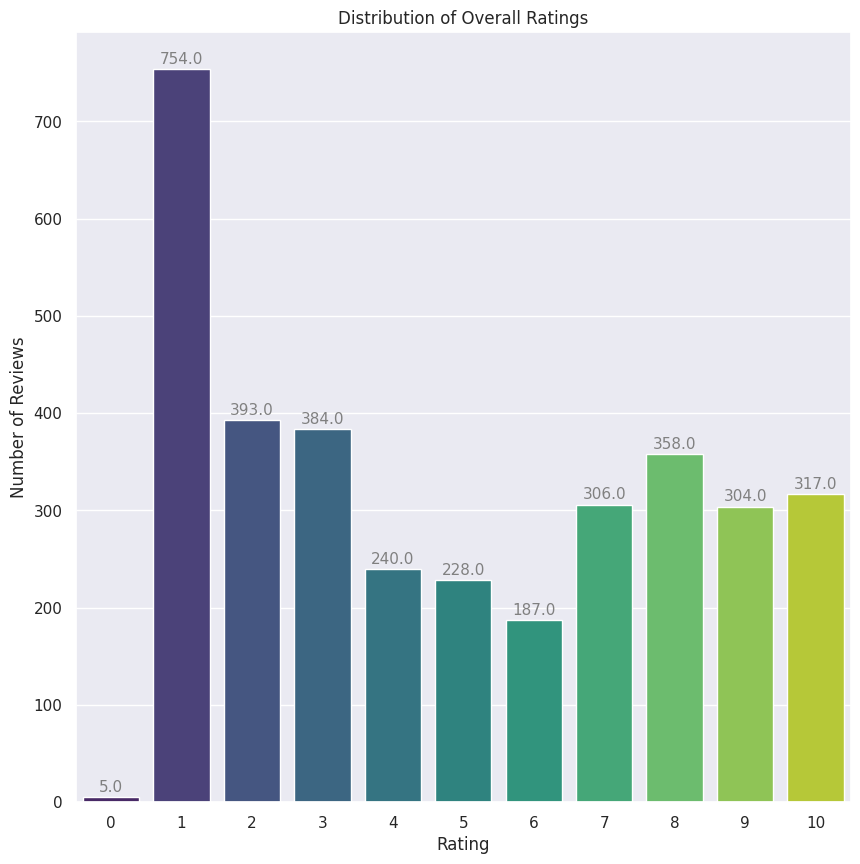

In [ ]:
import matplotlib.pyplot as plt

import seaborn as sns

# Setting aesthetics for plots

sns.set_theme(style="darkgrid")

plt.figure(figsize=(10, 10))

ax = sns.countplot(data= review_df, x='rating', palette='viridis')

# Add counts above the bars

for p in ax.patches:

    ax.annotate(f'{p.get_height()}', (p.get_x() + p.get_width() / 2., p.get_height()),

                ha='center', va='center', fontsize=11, color='grey', xytext=(0, 7),

                textcoords='offset points')




plt.title('Distribution of Overall Ratings')

plt.xlabel('Rating')

plt.ylabel('Number of Reviews')

plt.show()

The histogram above displays the distribution of overall ratings given by passengers. Ratings range from 1 to 10, with 1 being the lowest and 10 being the highest. We can observe that:

    Ratings are distributed across all possible values.
    There is a high frequency of low ratings (1 and 2), indicating a significant number of dissatisfied customers.
    The number of high ratings (8, 9, 10) is relatively lower, showing fewer extremely satisfied customers.

We can clearly see highest number of people have rated their overall experience as 1(754 people). Only half of the people(317) have given BA a full rating of 10.

## **Seasonal Trends: Rating vs Date-Flown:**
Let's plot a line graph and check if there are any seasonal trends of their flight month with their reviews.

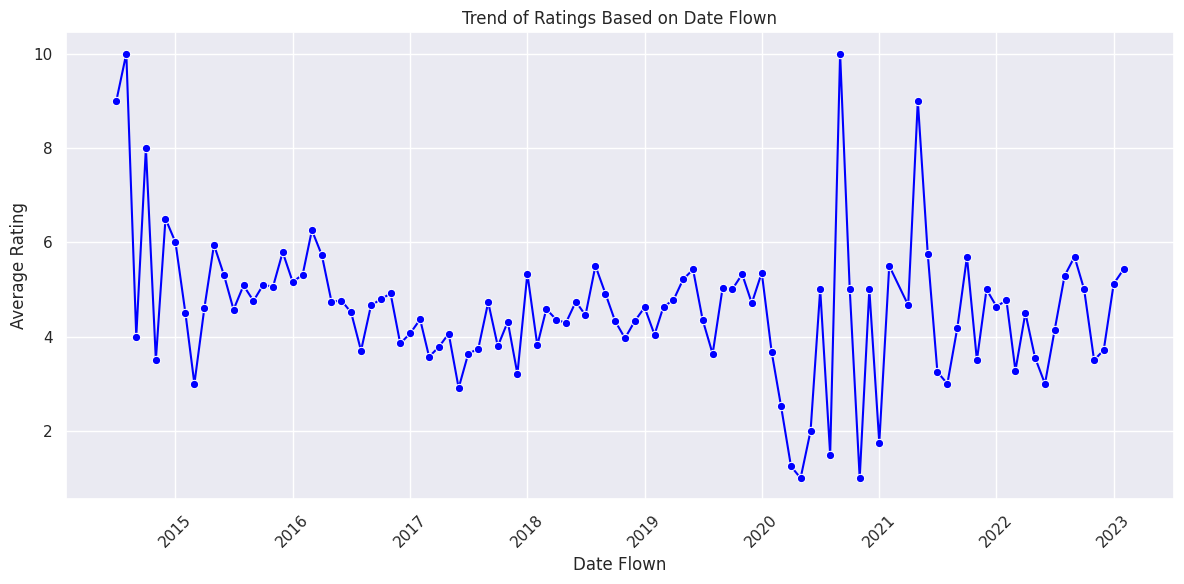

In [ ]:
# Dropping rows where 'Date Flown' is NaN as it is crucial for this analysis

date_flown_analysis = review_df.dropna(subset=['Date Flown']).copy()

# Grouping by 'Date Flown' and getting the mean rating for each date

date_flown_grouped = date_flown_analysis.groupby('Date Flown').agg({'rating': 'mean'}).reset_index()

# Plotting the trend of ratings based on 'Date Flown'

plt.figure(figsize=(12, 6))

sns.lineplot(data=date_flown_grouped, x='Date Flown', y='rating', color='blue', marker='o')

plt.title('Trend of Ratings Based on Date Flown')

plt.xlabel('Date Flown')

plt.ylabel('Average Rating')

plt.xticks(rotation=45)

plt.tight_layout()

plt.show()

We can see that the maximum change in Average Review rating has happened during starting of 2020 to mid 2022, which is understandable as due to Covid there were a lot of flight and travel restrictions. Hence, we see the drastic rise and fall of the Average Review Rating during this period. Covid 19 has effected a lot of people during this period even the travellers.

## **Average ratings based on the month of Flight**

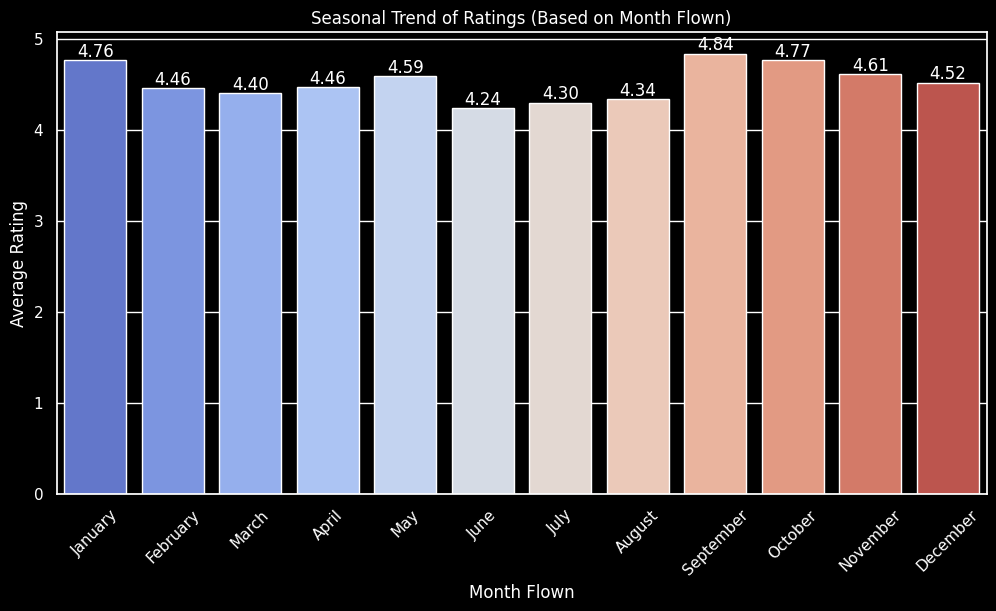

In [ ]:
# Extracting month from 'Date Flown' for seasonal analysis
date_flown_analysis['Month Flown'] = date_flown_analysis['Date Flown'].dt.month

# Grouping by month and getting the mean rating for each month
month_grouped = date_flown_analysis.groupby('Month Flown').agg({'rating': 'mean'}).reset_index()

# Plotting the trend of ratings based on the month flown with a dark background and light text
plt.figure(figsize=(12, 6))

# Set dark background
plt.style.use('dark_background')

sns.barplot(data=month_grouped, x='Month Flown', y='rating', palette='coolwarm')

# Defining month names for better interpretation
month_names = [

    'January', 'February', 'March', 'April', 'May', 'June',

    'July', 'August', 'September', 'October', 'November', 'December'

]


plt.xticks(ticks=range(12), labels=month_names, rotation=45)

# Add counts above the bars
for i, row in month_grouped.iterrows():

    plt.text(i, row.rating, f'{row.rating:.2f}', ha='center', va='bottom', color='white')


plt.title('Seasonal Trend of Ratings (Based on Month Flown)', color='white')

plt.gca().set_facecolor('black')

plt.xlabel('Month Flown', color='white')

plt.ylabel('Average Rating', color='white')

# Show the plot

plt.show()

September, January and October are the months which got the highest Avg review rating in that order. And the lowest one are June, July, August.

## **Average Rating for different Routes**
Let's calculate Avg. rating for different routes with different origin and destination Airports. For that we need to extract Departure and Arrival Airports from our Route Column and then we can calculate the Avg.

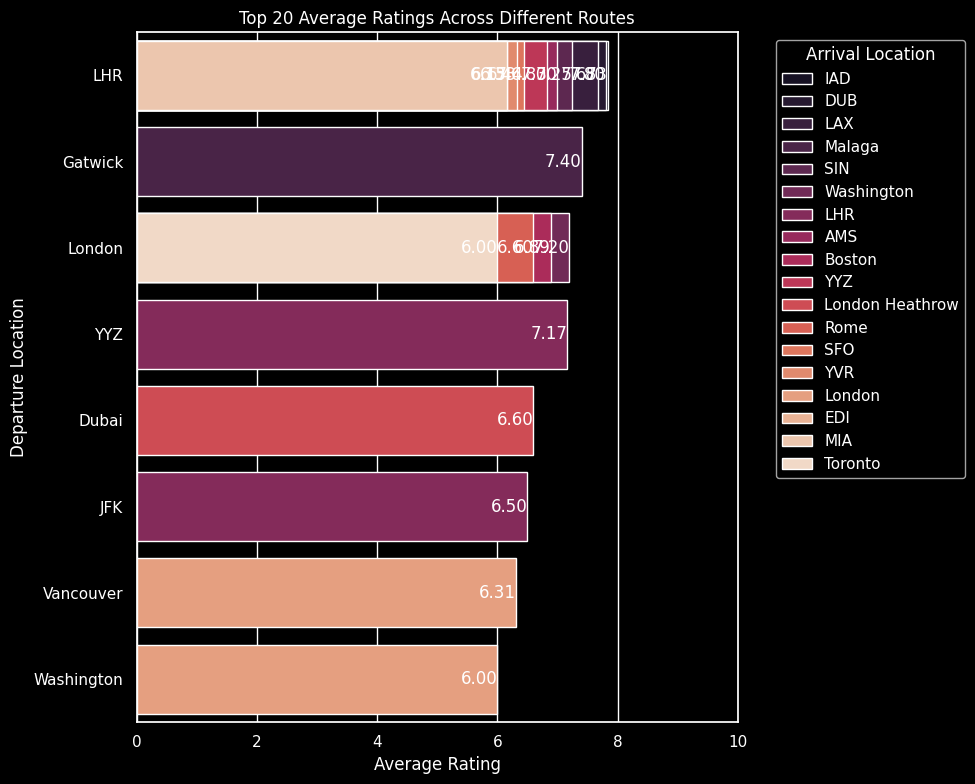

In [ ]:
# Dropping rows where 'Route' is NaN as it is crucial for this analysis
route_analysis = review_df.dropna(subset=['Route']).copy()

# Extracting departure and arrival locations into separate columns
route_analysis[['Departure', 'Arrival']] = route_analysis['Route'].str.extract(r'([A-Za-z\s]+) to ([A-Za-z\s]+)')
route_analysis = route_analysis.dropna(subset = ['Arrival'])

# Grouping by Departure and Arrival locations and getting the mean rating for each pair
route_grouped = route_analysis.groupby(['Departure', 'Arrival']).agg({'rating': ['mean', 'count']}).reset_index()
route_grouped.columns = ['Departure', 'Arrival', 'Average Rating', 'Review Count']

# Filtering routes with a minimum number of reviews, for example, at least 5 reviews
min_reviews = 5
route_grouped = route_grouped[route_grouped['Review Count'] >= min_reviews]

# Sorting routes by average rating for better visualization and taking top 20 routes
route_grouped = route_grouped.sort_values(by='Average Rating', ascending=False).head(20)

# Plotting the ratings across different routes
plt.figure(figsize=(10, 8))

barplot = sns.barplot(data=route_grouped, y='Departure', x='Average Rating', hue='Arrival', dodge=False, palette='rocket')

# Adding the text labels for each bar
for p in barplot.patches:
    width = p.get_width()    # get bar length
    plt.text(p.get_x() + width,       # set the text at the end of the bar
             p.get_y() + p.get_height() / 2, # get Y coordinate + half of the bar height
             '{:1.2f}'.format(width), # Y label is formatted to 2 decimal places
             ha = 'right',   # horizontal alignment
             va = 'center')   # vertical alignment

plt.title('Top 20 Average Ratings Across Different Routes')

plt.xlabel('Average Rating')

plt.ylabel('Departure Location')

plt.xlim(0, 10)  # Setting x-axis limit for better interpretation

plt.legend(title='Arrival Location', bbox_to_anchor=(1.05, 1), loc='upper left')  # Moving legend outside the plot

plt.tight_layout()

plt.show()

The bar plot above illustrates the average ratings for different flight routes, specifically focusing on the departure and arrival locations. Each bar represents the average rating for flights departing from a specific location, and the colors within each bar indicate the arrival locations.

* The plot shows the top 20 routes based on average ratings.
* Each route (combination of departure and arrival locations) has varied ratings, indicating differences in customer satisfaction. With London Heathrow(LHR) having the best Avg. rating(approx 8) and Washington having the worst
* The diversity in colors within each bar signifies multiple destinations from a single departure location, each with distinct average ratings. Like for example we can see London Heathrow has a few other Arrival Locations like Rome, IAD, DUB, LAX etc.

## **Lowest 20 Avg Rating according to Routes**

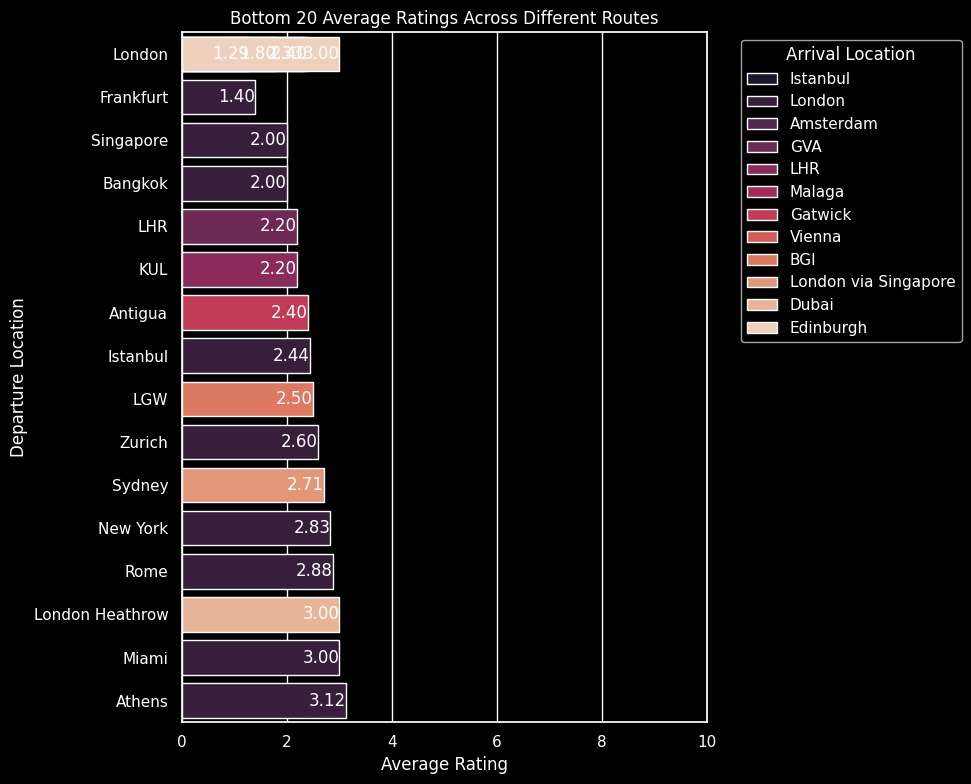

In [ ]:
# Dropping rows where 'Route' is NaN as it is crucial for this analysis
route_analysis = review_df.dropna(subset=['Route']).copy()

# Extracting departure and arrival locations into separate columns
route_analysis[['Departure', 'Arrival']] = route_analysis['Route'].str.extract(r'([A-Za-z\s]+) to ([A-Za-z\s]+)')
route_analysis = route_analysis.dropna(subset = ['Arrival'])

# Grouping by Departure and Arrival locations and getting the mean rating for each pair
route_grouped = route_analysis.groupby(['Departure', 'Arrival']).agg({'rating': ['mean', 'count']}).reset_index()
route_grouped.columns = ['Departure', 'Arrival', 'Average Rating', 'Review Count']

# Filtering routes with a minimum number of reviews, for example, at least 5 reviews
min_reviews = 5
route_grouped = route_grouped[route_grouped['Review Count'] >= min_reviews]

# Sorting routes by average rating for better visualization and taking top 20 routes
route_grouped = route_grouped.sort_values(by='Average Rating', ascending=True).head(20)

# Plotting the ratings across different routes
plt.figure(figsize=(10, 8))

barplot = sns.barplot(data=route_grouped, y='Departure', x='Average Rating', hue='Arrival', dodge=False, palette='rocket')

# Adding the text labels for each bar
for p in barplot.patches:
    width = p.get_width()    # get bar length
    plt.text(p.get_x() + width,       # set the text at the end of the bar
             p.get_y() + p.get_height() / 2, # get Y coordinate + half of the bar height
             '{:1.2f}'.format(width), # Y label is formatted to 2 decimal places
             ha = 'right',   # horizontal alignment
             va = 'center')   # vertical alignment

plt.title('Bottom 20 Average Ratings Across Different Routes')

plt.xlabel('Average Rating')

plt.ylabel('Departure Location')

plt.xlim(0, 10)  # Setting x-axis limit for better interpretation

plt.legend(title='Arrival Location', bbox_to_anchor=(1.05, 1), loc='upper left')  # Moving legend outside the plot

plt.tight_layout()

plt.show()

Here we can see the lowest 20 Departure Locations according to their Average Rating of flying to another Arrival Location. As we can see Frankfurt followed by Singapore, Bangkok has the lowest avg. rating accross different Routes.

In [ ]:
route_analysis.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2688 entries, 0 to 2701
Data columns (total 19 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   date                    2688 non-null   datetime64[ns]
 1   rating                  2688 non-null   int64         
 2   rev_id                  2688 non-null   int64         
 3   Aircraft                1807 non-null   object        
 4   Type Of Traveller       2686 non-null   object        
 5   Seat Type               2687 non-null   object        
 6   Route                   2688 non-null   object        
 7   Date Flown              2685 non-null   datetime64[ns]
 8   Seat Comfort            2590 non-null   float64       
 9   Cabin Staff Service     2582 non-null   float64       
 10  Food & Beverages        2352 non-null   float64       
 11  Ground Service          2630 non-null   float64       
 12  Value For Money         2688 non-null   float64 

## **Distribution of ratings based on the type of traveller (e.g., Solo, Family, Business)**

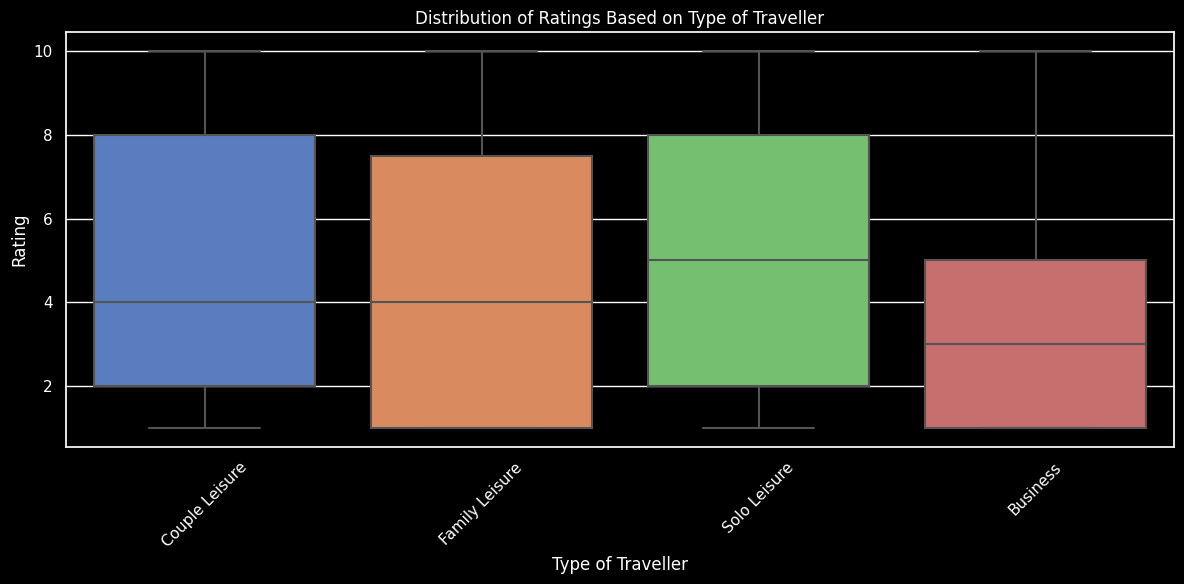

In [ ]:
# Dropping rows where 'Type Of Traveller' is NaN

traveller_type_analysis = review_df.dropna(subset=['Type Of Traveller']).copy()

# Plotting the distribution of ratings based on the type of traveller

plt.figure(figsize=(12, 6))

sns.boxplot(data=traveller_type_analysis, x='Type Of Traveller', y='rating', palette='muted')

plt.title('Distribution of Ratings Based on Type of Traveller')

plt.xlabel('Type of Traveller')

plt.ylabel('Rating')

plt.xticks(rotation=45)

plt.tight_layout()

plt.show()

The boxplot illustrates the distribution of ratings based on the type of traveller (e.g., Solo, Family, Business). Each box represents the interquartile range (IQR) of ratings, showing the middle 50% of ratings for each traveller type. The line inside each box represents the median rating.

*   The median ratings for different traveller types are relatively similar, but
the spread (variability) of ratings varies.

*   Some traveller types, such as "Family Leisure" and "Couple Leisure", have a wider range of ratings, indicating diverse levels of satisfaction among these travellers.

*  Whereas, Business has a narrower range of ratings but with lower customer satisfaction than usual.

## **Seat Type Analysis: Distribution of ratings based on the seat type**

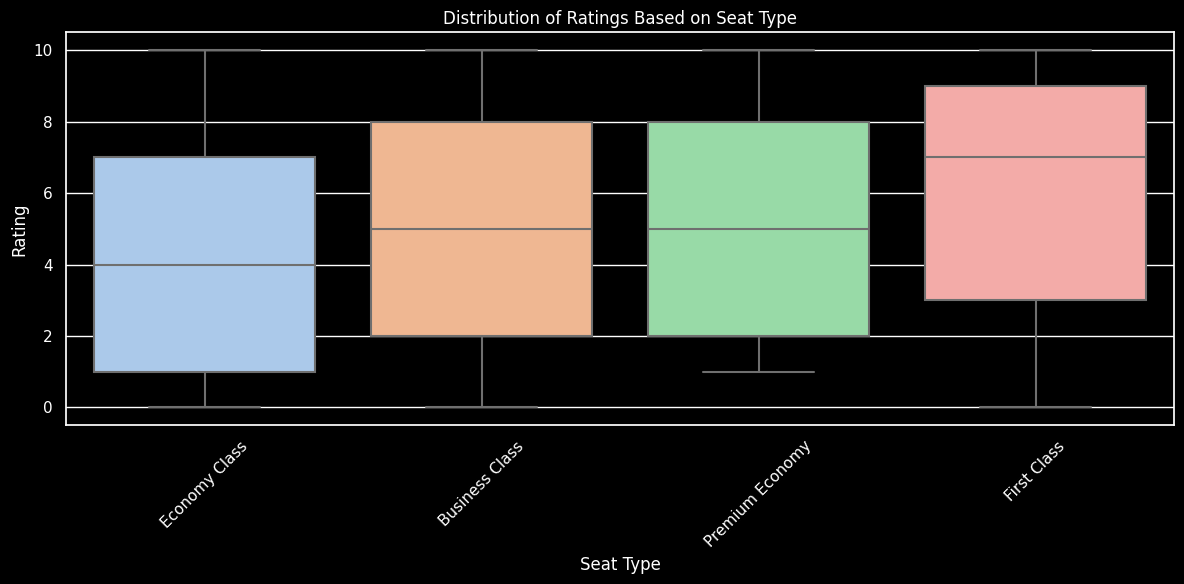

In [ ]:
# Dropping rows where 'Seat Type' is NaN

seat_type_analysis = review_df.dropna(subset=['Seat Type']).copy()

# Plotting the distribution of ratings based on the seat type

plt.figure(figsize=(12, 6))

sns.boxplot(data=seat_type_analysis, x='Seat Type', y='rating', palette='pastel')

plt.title('Distribution of Ratings Based on Seat Type')

plt.xlabel('Seat Type')

plt.ylabel('Rating')

plt.xticks(rotation=45)

plt.tight_layout()

plt.show()

The boxplot above illustrates the distribution of ratings based on seat types, such as Economy, Business, and First Class.

*   Different seat types exhibit varied rating distributions, which indicates that the seat type influences customer satisfaction and ratings.

    
*   The median rating seems relatively consistent across different seat types, except for Economy Class having lowest Median Rating(4) & First Class Median Rating(7) which is higher than any other seat type. Which is expected for a First Class Service in general. But there's variation in the spread and distribution of ratings among the seat types.



## **Recommendation Analysis by Customer Rating**
Checking the distribution of User Rating by Recommended Column. We are going to do a box plot that will give the distribution of rating according to if the user recommends this airline or not.

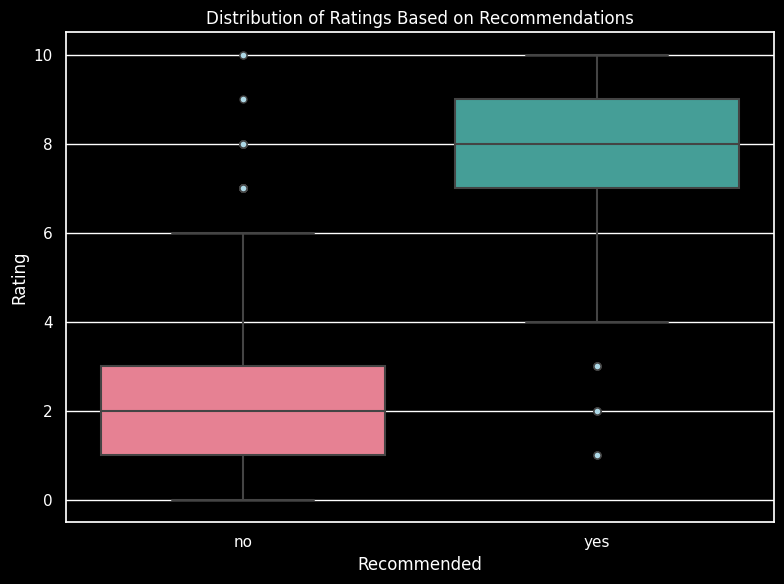

In [ ]:
# Checking and cleaning the 'Recommended' column

review_df['Recommended'] =review_df['Recommended'].astype('category')

# Dropping rows where 'Recommended' or 'rating' is NaN as they are crucial for this analysis

recommendation_analysis =review_df.dropna(subset=['Recommended', 'rating']).copy()

# Converting 'rating' column to numeric for the recommendation analysis

recommendation_analysis['rating'] = pd.to_numeric(recommendation_analysis['rating'], errors='coerce')

# Dropping any rows that failed to convert

recommendation_analysis = recommendation_analysis.dropna(subset=['rating'])

# Plotting the distribution of ratings based on recommendations

plt.figure(figsize=(8, 6))

sns.boxplot(data=recommendation_analysis, x='Recommended', y='rating', palette='husl', flierprops=dict(marker='o', markersize=5, linestyle='none', markerfacecolor='lightblue'))

plt.title('Distribution of Ratings Based on Recommendations')

plt.xlabel('Recommended')

plt.ylabel('Rating')

plt.tight_layout()

plt.show()

The boxplot illustrates the distribution of ratings in relation to whether customers recommend British Airways or not.



*   There is a clear difference in the distribution of ratings between those who recommend and those who do not.
    
*   Customers who recommend British Airways tend to give higher ratings, as indicated by the higher median and smaller spread of the boxplot for 'yes'.

*   In contrast, those who do not recommend the airline have a much wider range of ratings, with a significantly lower median, indicating a more varied and generally less positive experience.

*  There are few outliers in both cases of no and yes recommendation choice. As we can see some customer are satisfied with their reviews yet they do not recommend this airline maybe due to some other experiences. Similalry, few customers are recommending the British Airways Services but they themselves had terrible experiences.

This analysis highlights the relationship between overall customer satisfaction (as reflected in ratings) and the likelihood of recommending the airline.

## **Aircraft Type vs Avg Rating Analysis**

In [ ]:
# Find the unique aircrafts and count their appearances

aircraft_counts = review_df['Aircraft'].value_counts()

# Display the result

aircraft_counts

A320                   335
Boeing 777             262
Boeing 747-400         182
A380                   158
Boeing 777-200         122
                      ... 
A319 / Boeing 787-9      1
Airbus A32               1
A320 / Boeing 787-9      1
Boeing 787-9, A380       1
Airbus 319               1
Name: Aircraft, Length: 189, dtype: int64

In [ ]:
# Count the total number of unique aircrafts

total_unique_aircrafts = review_df['Aircraft'].nunique()

total_unique_aircrafts

189

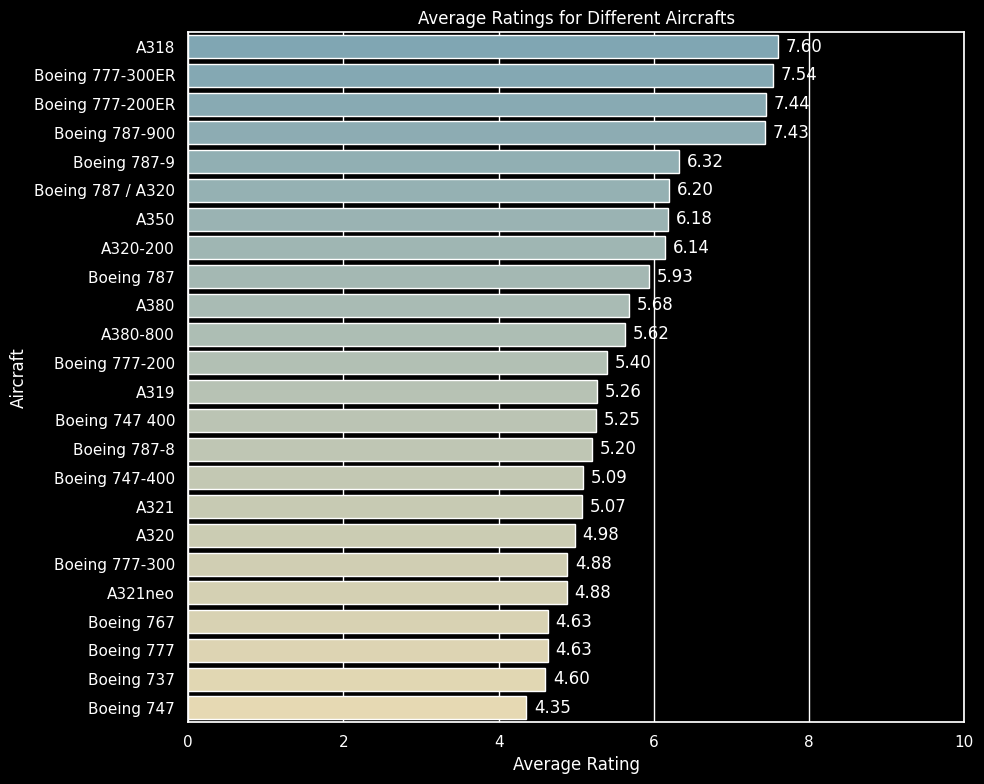

In [ ]:
# Dropping rows where 'rating' or 'Aircraft' is NaN
aircraft_analysis = review_df.dropna(subset=['rating', 'Aircraft'])

# Grouping by Aircraft and calculating the mean rating and count
aircraft_grouped = aircraft_analysis.groupby('Aircraft').agg({'rating': ['mean', 'count']}).reset_index()
aircraft_grouped.columns = ['Aircraft', 'Average Rating', 'Review Count']

# Optionally, filter out Aircrafts with very few reviews
min_reviews = 5
aircraft_grouped = aircraft_grouped[aircraft_grouped['Review Count'] >= min_reviews]

# Sorting for better visualization
aircraft_grouped = aircraft_grouped.sort_values(by='Average Rating', ascending=False)

# Plotting the ratings for different Aircrafts
plt.figure(figsize=(10, 8))
aircraft_barplot = sns.barplot(data=aircraft_grouped, x='Average Rating', y='Aircraft', palette="blend:#7AB,#EDA")

# Adding the text labels for each bar
for p in aircraft_barplot.patches:
    width = p.get_width()  # get bar length
    plt.text(p.get_x() + width + 0.1,  # set the text slightly right of the end of the bar
             p.get_y() + p.get_height() / 2, # get Y coordinate + half of the bar height
             '{:1.2f}'.format(width),   # Y label is formatted to 2 decimal places
             ha = 'left',  # horizontal alignment
             va = 'center')  # vertical alignment

plt.title('Average Ratings for Different Aircrafts')
plt.xlabel('Average Rating')
plt.ylabel('Aircraft')
plt.xlim(0, 10)  # Setting x-axis limit for better interpretation
plt.tight_layout()
plt.show()

We can clearly see Aircrafts like A318, Boeing 777 , 787 variants have better avg. rating which means better customer satisfaction in their overall journeys.